### Importing needed libraries 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from huggingface_hub import notebook_login

from datasets import load_dataset, DatasetDict

from transformers import AutoImageProcessor, ViTForImageClassification

from transformers import Trainer, TrainingArguments

import evaluate

In [3]:
#load the dataset, i am going to use the food101 dataset from huggingface
dataset = load_dataset("food101")

In [4]:
labels = dataset['train'].unique('label')
print(len(labels),labels)

101 [6, 79, 81, 53, 10, 20, 77, 48, 86, 84, 76, 34, 51, 21, 64, 0, 43, 44, 73, 57, 14, 5, 46, 55, 93, 98, 38, 11, 99, 72, 22, 59, 70, 16, 2, 58, 83, 96, 39, 49, 45, 88, 9, 26, 94, 4, 65, 32, 27, 36, 87, 69, 85, 25, 40, 19, 35, 56, 42, 60, 68, 100, 41, 92, 24, 3, 89, 75, 17, 97, 61, 33, 80, 30, 8, 74, 66, 31, 18, 67, 37, 13, 63, 28, 47, 52, 54, 1, 82, 91, 95, 7, 29, 78, 15, 23, 12, 62, 50, 71, 90]


In [5]:
dataset['train'][0]

{'image': <PIL.Image.Image image mode=RGB size=384x512>, 'label': 6}

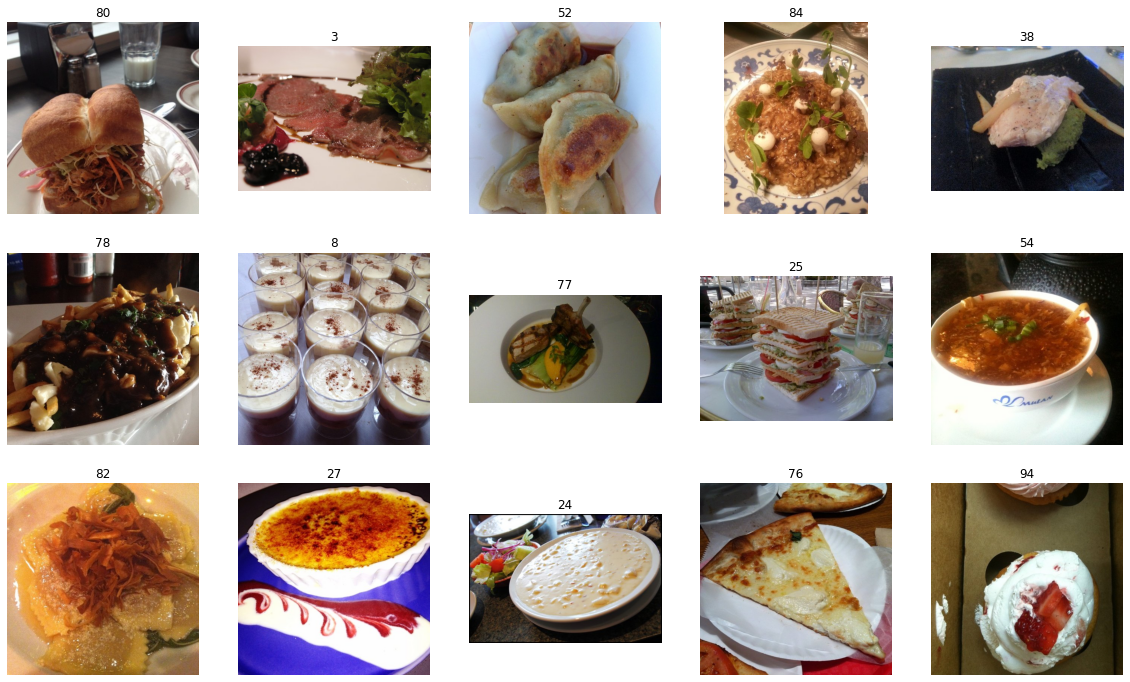

In [6]:
def show_samples(ds,rows,cols):
    samples = ds.shuffle().select(np.arange(rows*cols)) # selecting random images
    fig = plt.figure(figsize=(cols*4,rows*4))
    # plotting
    for i in range(rows*cols):
        img = samples[i]['image']
        label = samples[i]['label']
        fig.add_subplot(rows,cols,i+1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')
            
show_samples(dataset['train'],rows=3,cols=5)

In [7]:
dataset = DatasetDict({
    'train': dataset['train'],
    'test': dataset['validation']
})

In [8]:
processor = AutoImageProcessor.from_pretrained('google/vit-base-patch16-224')
processor

c:\Programming\Python\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ViTImageProcessor {
  "_valid_processor_keys": [
    "images",
    "do_resize",
    "size",
    "resample",
    "do_rescale",
    "rescale_factor",
    "do_normalize",
    "image_mean",
    "image_std",
    "return_tensors",
    "data_format",
    "input_data_format"
  ],
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [9]:
label2id = {c:idx for idx,c in enumerate(labels)}
id2label = {idx:c for idx,c in enumerate(labels)}
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224',
    num_labels = len(labels),
    id2label = id2label,
    label2id = label2id,
    ignore_mismatched_sizes = True
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([101]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([101, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
for name,p in model.named_parameters():
    if not name.startswith('classifier'):
        p.requires_grad = False

In [11]:
def transforms(batch):
    batch['image'] = [x.convert('RGB') for x in batch['image']]
    inputs = processor(batch['image'],return_tensors='pt')
    inputs['labels']=[label2id[y] for y in batch['label']]
    return inputs

dataset = dataset.with_transform(transforms)

In [12]:
num_params = sum([p.numel() for p in model.parameters()])
trainable_params = sum([p.numel() for p in model.parameters() if p.requires_grad])

print(f"{num_params = :,} | {trainable_params = :,}")

num_params = 85,876,325 | trainable_params = 77,669


In [13]:
for name,p in model.named_parameters():
    if not name.startswith('classifier'):
        p.requires_grad = False

In [14]:
training_args = TrainingArguments(
    output_dir="./food-101-finetuned-model",
    per_device_train_batch_size=8,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_steps=100,
    num_train_epochs=1,
    learning_rate=3e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=True,
    report_to='tensorboard',
    load_best_model_at_end=True,
)

c:\Programming\Python\lib\site-packages\transformers\training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [15]:
accuracy = evaluate.load('accuracy')
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits,axis=1)
    score = accuracy.compute(predictions=predictions, references=labels)
    return score

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=processor
)

In [31]:
trainer.train()

  0%|          | 0/9469 [00:00<?, ?it/s]

{'loss': 1.7141, 'grad_norm': 7.487691879272461, 'learning_rate': 0.0002968317668180378, 'epoch': 0.01}
{'loss': 1.4323, 'grad_norm': 6.214428901672363, 'learning_rate': 0.0002936635336360756, 'epoch': 0.02}
{'loss': 1.2775, 'grad_norm': 5.6321330070495605, 'learning_rate': 0.0002904953004541134, 'epoch': 0.03}
{'loss': 1.2816, 'grad_norm': 6.7969584465026855, 'learning_rate': 0.0002873270672721512, 'epoch': 0.04}
{'loss': 1.2762, 'grad_norm': 6.97235107421875, 'learning_rate': 0.000284158834090189, 'epoch': 0.05}
{'loss': 1.2373, 'grad_norm': 5.486090183258057, 'learning_rate': 0.00028099060090822683, 'epoch': 0.06}
{'loss': 1.1401, 'grad_norm': 3.0795063972473145, 'learning_rate': 0.00027782236772626464, 'epoch': 0.07}
{'loss': 1.0901, 'grad_norm': 5.8202900886535645, 'learning_rate': 0.00027465413454430245, 'epoch': 0.08}
{'loss': 1.0041, 'grad_norm': 4.246810436248779, 'learning_rate': 0.00027148590136234026, 'epoch': 0.1}
{'loss': 0.9934, 'grad_norm': 5.755637168884277, 'learning_

c:\Programming\Python\lib\site-packages\PIL\TiffImagePlugin.py:866: UserWarning: Truncated File Read
  warnings.warn(str(msg))


{'loss': 0.9248, 'grad_norm': 5.8424530029296875, 'learning_rate': 0.0002524765022705671, 'epoch': 0.16}
{'loss': 0.9284, 'grad_norm': 5.277805328369141, 'learning_rate': 0.00024930826908860487, 'epoch': 0.17}
{'loss': 0.9137, 'grad_norm': 6.6619873046875, 'learning_rate': 0.00024614003590664273, 'epoch': 0.18}
{'loss': 0.8963, 'grad_norm': 5.51943826675415, 'learning_rate': 0.00024297180272468054, 'epoch': 0.19}
{'loss': 0.9435, 'grad_norm': 5.245814323425293, 'learning_rate': 0.00023980356954271832, 'epoch': 0.2}
{'loss': 0.9159, 'grad_norm': 6.2571516036987305, 'learning_rate': 0.00023663533636075616, 'epoch': 0.21}
{'loss': 0.994, 'grad_norm': 3.9157769680023193, 'learning_rate': 0.00023346710317879394, 'epoch': 0.22}
{'loss': 0.8031, 'grad_norm': 4.6235857009887695, 'learning_rate': 0.00023029886999683175, 'epoch': 0.23}
{'loss': 0.8542, 'grad_norm': 5.753032207489014, 'learning_rate': 0.00022713063681486956, 'epoch': 0.24}
{'loss': 0.8993, 'grad_norm': 3.404986619949341, 'learnin

  0%|          | 0/3157 [00:00<?, ?it/s]

{'eval_loss': 0.5578122138977051, 'eval_accuracy': 0.8447128712871287, 'eval_runtime': 8034.2544, 'eval_samples_per_second': 3.143, 'eval_steps_per_second': 0.393, 'epoch': 1.0}
{'train_runtime': 32395.5989, 'train_samples_per_second': 2.338, 'train_steps_per_second': 0.292, 'train_loss': 0.8670025111528873, 'epoch': 1.0}


TrainOutput(global_step=9469, training_loss=0.8670025111528873, metrics={'train_runtime': 32395.5989, 'train_samples_per_second': 2.338, 'train_steps_per_second': 0.292, 'total_flos': 5.8752267138432e+18, 'train_loss': 0.8670025111528873, 'epoch': 1.0})

In [32]:
kwargs = {
    "finetuned_from": model.config._name_or_path,
    "dataset": 'food101',
    "tasks": "image-classification",
    "tags": ['image-classification'],
}

In [33]:
notebook_login()

In [34]:
trainer.save_model()
trainer.push_to_hub('Food-Classification-v1', **kwargs)

CommitInfo(commit_url='https://huggingface.co/Mullerjo/food-101-finetuned-model/commit/3913dab1d72088822ecec166bc1a4b162d4a235e', commit_message='Food-Classification-v1', commit_description='', oid='3913dab1d72088822ecec166bc1a4b162d4a235e', pr_url=None, pr_revision=None, pr_num=None)